## Librairies Importations

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import gaussian_kde

%pip install lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
%pip install xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingClassifier




from tqdm.notebook import tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Dataset and visualization

In [30]:
dataset_train_path = r'C:\Users\barta\Documents\cours\iaprojets\projet_aa\repo\Projet-AARES-20260202\part_1\data\raw\spotify_dataset_train.csv'
dataset_test_path = r'C:\Users\barta\Documents\cours\iaprojets\projet_aa\repo\Projet-AARES-20260202\part_1\data\raw\spotify_dataset_test.csv'

dataset_train = pd.read_csv(dataset_train_path)
dataset_test = pd.read_csv(dataset_test_path)

In [31]:
print("="*40)
dataset_test.info()
print("="*40)

dataset_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   release_date      2833 non-null   object 
 1   explicit          2833 non-null   bool   
 2   popularity        2833 non-null   int64  
 3   danceability      2833 non-null   float64
 4   energy            2833 non-null   float64
 5   key               2833 non-null   int64  
 6   loudness          2833 non-null   float64
 7   mode              2833 non-null   int64  
 8   speechiness       2833 non-null   float64
 9   acousticness      2833 non-null   float64
 10  instrumentalness  2833 non-null   float64
 11  liveness          2833 non-null   float64
 12  valence           2833 non-null   float64
 13  tempo             2833 non-null   float64
 14  duration_ms       2833 non-null   int64  
 15  time_signature    2833 non-null   int64  
dtypes: bool(1), float64(9), int64(5), object(1

,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2018-03-16,True,83,0.699,0.304,1,-11.192,1,0.0993,0.77900,0.000993,0.1370,0.271,119.705,160184,4
1,2003,False,44,0.590,0.722,4,-5.783,1,0.0265,0.00052,0.000009,0.0712,0.670,116.035,166645,4
2,2012-01-01,False,0,0.362,0.435,2,-7.241,1,0.0280,0.27400,0.000001,0.1580,0.349,141.970,220693,4
3,2001-10-23,False,57,0.571,0.617,2,-5.032,1,0.0348,0.32800,0.000000,0.1150,0.574,88.154,187373,4
4,2020-09-18,False,56,0.578,0.748,0,-5.609,0,0.0460,0.03260,0.002550,0.1430,0.170,123.973,185806,4


In [32]:
dataset_train.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,25492.000000,25492.000000,25492.000000,25492.000000,25492.000000,25492.000000,25492.000000,25492.000000,25492.000000,25492.000000,25492.000000,25492.000000,2.549200e+04,25492.000000
mean,31.185784,0.600785,0.666671,5.319630,-7.827989,0.617841,0.098590,0.247458,0.121762,0.194426,0.517368,122.020427,2.357300e+05,3.949004
std,26.647985,0.167052,0.223217,3.577066,4.190793,0.485925,0.100955,0.298900,0.264749,0.160047,0.252768,28.000996,9.605836e+04,0.313024
min,0.000000,0.000000,0.000020,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.008290,0.000000,0.000000,1.344000e+04,0.000000
25%,0.000000,0.494000,0.526000,2.000000,-9.618250,0.000000,0.038000,0.012900,0.000000,0.093475,0.318000,99.996000,1.833298e+05,4.000000
50%,33.000000,0.613000,0.700000,5.000000,-6.944500,1.000000,0.054400,0.098400,0.000099,0.129000,0.518000,123.130000,2.179200e+05,4.000000
75%,54.000000,0.723000,0.846000,8.000000,-5.047750,1.000000,0.111000,0.415000,0.031700,0.254000,0.721000,139.936000,2.656698e+05,4.000000
max,98.000000,0.988000,1.000000,11.000000,1.869000,1.000000,0.934000,0.996000,0.989000,0.988000,0.988000,244.613000,2.516987e+06,5.000000


## Graphics

https://www.kaggle.com/code/varunsaikanuri/spotify-data-visualization

In [33]:
df_train_copy = dataset_train.copy() # pour eviter les pb

df_train_copy['release_date'] = pd.to_datetime(df_train_copy['release_date'],format='mixed')

min_date = df_train_copy['release_date'].min()
df_train_copy['days_since_1900'] = (df_train_copy['release_date'] - min_date).dt.days


fig = make_subplots(rows=4, cols=3, subplot_titles=(
    '<i>popularity', '<i>danceability', '<i>energy', 
    '<i>loudness', '<i>speechiness', '<i>acousticness','<i>instrumentalness', 
    '<i>liveness', '<i>valence', '<i>tempo','<i>duration_ms'))

fig.add_trace(go.Histogram(x=dataset_train['popularity'], name='popularity'), row=1, col=1)
fig.add_trace(go.Histogram(x=dataset_train['danceability'], name='danceability'), row=1, col=2)
fig.add_trace(go.Histogram(x=dataset_train['energy'], name='energy'), row=1, col=3)
fig.add_trace(go.Histogram(x=dataset_train['loudness'], name='loudness'), row=2, col=1)
fig.add_trace(go.Histogram(x=dataset_train['speechiness'], name='speechiness'), row=2, col=2)
fig.add_trace(go.Histogram(x=dataset_train['acousticness'], name='acousticness'), row=2, col=3)
fig.add_trace(go.Histogram(x=dataset_train['instrumentalness'], name='instrumentalness'), row=3, col=1)
fig.add_trace(go.Histogram(x=dataset_train['liveness'], name='liveness'), row=3, col=2)
fig.add_trace(go.Histogram(x=dataset_train['valence'], name='valence'), row=3, col=3)
fig.add_trace(go.Histogram(x=dataset_train['tempo'], name='tempo'), row=4, col=1)
fig.add_trace(go.Histogram(x=dataset_train['duration_ms'], name='duration_ms'), row=4, col=2)
fig.add_trace(go.Histogram(x=df_train_copy['days_since_1900'], name='days_since_1900'), row=4, col=3)


fig.update_xaxes(title_text="Score (0-100)", row=1, col=1)      
fig.update_xaxes(title_text="Score (0-1)", row=1, col=2)         
fig.update_xaxes(title_text="Score (0-1)", row=1, col=3)         
fig.update_xaxes(title_text="dB", row=2, col=1)                  
fig.update_xaxes(title_text="Score (0-1)", row=2, col=2)         
fig.update_xaxes(title_text="Score (0-1)", row=2, col=3) 
fig.update_xaxes(title_text="Score (0-1)", row=3, col=1)         
fig.update_xaxes(title_text="Score (0-1)", row=3, col=2)         
fig.update_xaxes(title_text="Score (0-1)", row=3, col=3)         
fig.update_xaxes(title_text="BPM", row=4, col=1)      
fig.update_xaxes(title_text="ms", row=4, col=2)         
fig.update_xaxes(title_text="days", row=4, col=3)         


fig.update_layout(height=800, width=1000, title_text='<b>Feature Distribution')
fig.update_layout(template='plotly_dark', title_x=0.5)

## Popularity feature biais

In [34]:
px.histogram(x=dataset_train['popularity'], title='Distribution of Popularity', labels={'popularity': 'Popularity'}, template='plotly_dark')

In [35]:
popularity_without_zeros = dataset_train[dataset_train['popularity'] > 0]['popularity']
px.histogram(x=popularity_without_zeros, title='Distribution of Popularity (Without Zeros)', labels={'popularity': 'Popularity'}, template='plotly_dark')  

In [36]:
music_with_only_zeros = dataset_train[dataset_train['popularity'] == 0]
counts = music_with_only_zeros['genre'].value_counts()


df_plot = counts.reset_index()
df_plot.columns = ['genre', 'count']


fig = px.bar(df_plot.sort_values('count'), x='count', y='genre', orientation='h',
             title="Tracks with popularity = 0 by genre (all genres)",
             labels={'count':'Number of tracks','genre':'Genre'},
             template='plotly_dark', width=900, height=600)
fig.show()



In [37]:
# Filtrer
music_with_only_zeros = dataset_train[dataset_train['popularity'] == 0]

# Comptes
zero_counts = music_with_only_zeros['genre'].value_counts()
total_counts = dataset_train['genre'].value_counts()

# DataFrame combinée et taux
df_rates = pd.DataFrame({
    'genre': total_counts.index,
    'total': total_counts.values
})
df_rates['zero_count'] = df_rates['genre'].map(zero_counts).fillna(0).astype(int)
df_rates['taux'] = df_rates['zero_count'] / df_rates['total']


top_n = 22
df_plot = df_rates.sort_values('taux', ascending=False).head(top_n)

fig = px.bar(df_plot.sort_values('taux'), x='taux', y='genre', orientation='h',
             title=f"Tracks with popularity = 0 by genre (top {top_n})",
             labels={'taux':'Proportion (0-1)','genre':'Genre'},
             template='plotly_dark', width=900, height=600)
fig.show()

In [38]:
df = dataset_train[dataset_train['popularity'] > 0][['genre','popularity']].dropna()
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce').dropna().astype(int)



fig = px.histogram(df, x='popularity', facet_col='genre', facet_col_wrap=4,
                   nbins=100, range_x=[1,100], range_y=[0,min(100, df['popularity'].value_counts().max())],
                   labels={'popularity':'Popularity'},
                   title='Count of popularity (>0) per genre',
                   template='plotly_dark',
                   width=1000, height=1200)

#fig.update_xaxes(showticklabels=True, tick0=0, dtick=10, title_text='Popularity')
#fig.update_yaxes(autorange=True, title_text='Count')
# Vue plus precise :
fig.update_yaxes(matches=None, autorange=True, title_text='Count')
fig.update_xaxes(tick0=0, dtick=10, range=[0,100], title_text='Popularity')

fig.update_layout(margin=dict(t=80,l=50,r=50,b=50), showlegend=False)
fig.show()

## Preprocess
### Pipiline
- Conversion de explicit True False en 0 ou 1
- Release_date : On compte en nombre de jour par rapport à la sortie de la première musique
- Genres : One Hot / Label Encoding 
- Popularité : bcp de valeur à 0 -> Données manquante
- Réajuster les données dû aux biais de nombre de musique par genre, en particulier pour de la recommendation de musique 

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
le = LabelEncoder()

df_train_copy = dataset_train.copy() # pour eviter les pb
df_train_copy['explicit'] = df_train_copy['explicit'].fillna(False).astype(bool).astype(int)

df_train_copy['release_date'] = pd.to_datetime(df_train_copy['release_date'],format='mixed')

min_date = df_train_copy['release_date'].min()
df_train_copy['days_since_1900'] = (df_train_copy['release_date'] - min_date).dt.days


features = ['days_since_1900','explicit','popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 
            'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'duration_ms', 'time_signature']



X, y = df_train_copy[features], df_train_copy['genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [41]:
dataset_train_nozero = dataset_train[dataset_train['popularity'] > 0].copy()

df_train_copy_no = dataset_train_nozero.copy()  # pour eviter les pb
df_train_copy_no['release_date'] = pd.to_datetime(df_train_copy_no['release_date'], format='mixed')
min_date = df_train_copy_no['release_date'].min()
df_train_copy_no['days_since_1900'] = (df_train_copy_no['release_date'] - min_date).dt.days

X_nozero, y_nozero = df_train_copy_no[features], df_train_copy_no['genre']
X_train_nozero, X_val_nozero, y_train_nozero, y_val_nozero = train_test_split(X_nozero, y_nozero, test_size=0.20, random_state=42, stratify=y_nozero)

In [42]:
from sklearn.neighbors import KernelDensity

for g in df_train_copy['genre'].unique():
    genre_mask = df_train_copy['genre'] == g
    non_zero = df_train_copy[genre_mask & (df_train_copy['popularity'] > 0)]['popularity']
    zero_mask = genre_mask & (df_train_copy['popularity'] == 0)
    
    if not non_zero.empty and zero_mask.any():
        kde = KernelDensity(bandwidth=5, kernel='gaussian')
        kde.fit(non_zero.values.reshape(-1, 1))
        samples = kde.sample(n_samples=zero_mask.sum())
        df_train_copy.loc[zero_mask, 'popularity'] = np.clip(samples.flatten(), 0, 100)

X_kde, y_kde = df_train_copy[features], df_train_copy['genre']
X_train_kde, X_val_kde, y_train_kde, y_val_kde = train_test_split(X_kde, y_kde, test_size=0.20, random_state=42, stratify=y_kde)

C:\Users\barta\AppData\Local\Temp\ipykernel_30656\2497252023.py:12: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[64.54258937  0.         45.2356001  54.94141604 60.66206656 47.96786056
 51.9656001  30.61028189 76.40123382 53.35312347 22.33790048  0.
 59.87462389 67.0956579  50.25047046 56.70281025 61.0766301  41.61237686
 57.86957656 37.06076306 39.56335559 55.15256925 87.36406573 22.19923913
 67.46560192 13.19692078 56.52136109 78.31879999 51.82254225 43.07544516
 14.74663537 24.75200172 45.99433718 63.15250902 56.14247986 36.86451397
 57.18796046 43.02236723 40.60879574 54.17203794 68.78897752 60.25350312
 66.01883986 43.86440605 17.74441682 80.73969677 65.64049593 63.98906789
 51.04093531 66.00041687 62.22940489 51.92094911 58.94853455 73.52312527
 45.32774454 70.61603213 39.70650473 68.02231621 31.84465993 53.94075305
 45.78910708 67.83597633 49.99565215 61.81592929 58.29184675 72.14024312
 56.160

In [43]:
df = dataset_train[dataset_train['popularity'] > 0][['genre','popularity']].dropna()
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce').dropna().astype(int)
order = df['genre'].drop_duplicates().tolist()
df['genre'] = pd.Categorical(df['genre'], categories=order, ordered=True)
df_kde = df_train_copy[['genre','popularity']].dropna().copy()
df_kde['popularity'] = pd.to_numeric(df_kde['popularity'], errors='coerce').clip(0,100).round().astype(int)
df_kde['genre'] = pd.Categorical(df_kde['genre'], categories=order, ordered=True)

fig = px.histogram(df_kde, x='popularity', facet_col='genre', facet_col_wrap=4,
                   nbins=100, range_x=[0,100],
                   labels={'popularity':'Popularity'},
                   title='Count of popularity (KDE imputed) per genre',
                   template='plotly_dark',
                   width=1000, height=1200)

fig.update_yaxes(matches=None, autorange=True, title_text='Count')
fig.update_xaxes(tick0=0, dtick=10, range=[0,100], title_text='Popularity')

fig.update_layout(margin=dict(t=80,l=50,r=50,b=50), showlegend=False)
fig.show()

### Types de corrélation
- Genre avec la date release
- Tracer la répartition mais cette fois-ci en fonction des genres au lieu des densités
- La mode en fonction des enres
- 

## Classification - LGBM

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# Configuration du K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Stockage des résultats
scores_accuracy = []
scores_f1 = []
scores_auc = []
models = []

# Boucle de cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n{'='*50}")
    print(f"Fold {fold}/{n_splits}")
    print(f"{'='*50}")
    
    # Séparation des données
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Entraînement du modèle
    LGBM = LGBMClassifier(n_estimators=500, random_state=42, verbose=-1)
    LGBM.fit(X_train_fold, y_train_fold)
    
    # Prédictions
    y_pred_fold = LGBM.predict(X_val_fold)
    y_pred_proba_fold = LGBM.predict_proba(X_val_fold)[:, 1]
    
    # Calcul des métriques
    f1 = f1_score(y_val_fold, y_pred_fold, average='micro')
    scores_f1.append(f1)
    print(f"F1-Score: {f1:.4f}")




Fold 1/5
F1-Score: 0.4754

Fold 2/5
F1-Score: 0.4852

Fold 3/5
F1-Score: 0.4725

Fold 4/5
F1-Score: 0.4710

Fold 5/5
F1-Score: 0.4798


In [45]:
LGBM_nozero = LGBMClassifier(n_estimators=500, random_state=42, verbose=-1,)
LGBM_nozero.fit(X_train_nozero, y_train_nozero)
y_pred_val_nozero = LGBM_nozero.predict(X_val_nozero)

KeyboardInterrupt: 

In [ ]:
LGBM_KDE = LGBMClassifier(n_estimators=500, random_state=42, verbose=-1,)
LGBM_KDE.fit(X_train_kde, y_train_kde)
y_pred_val_KDE = LGBM_KDE.predict(X_val_kde)

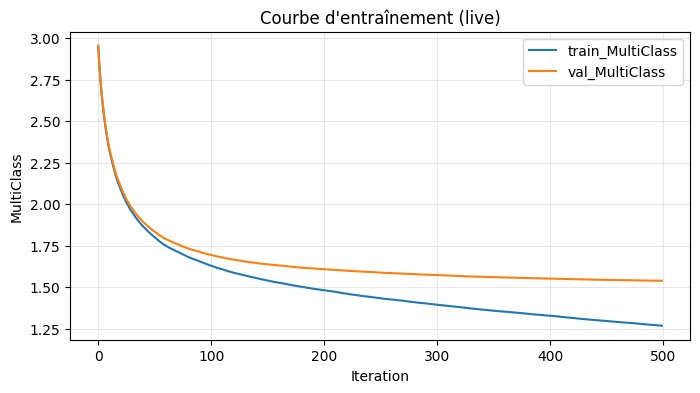

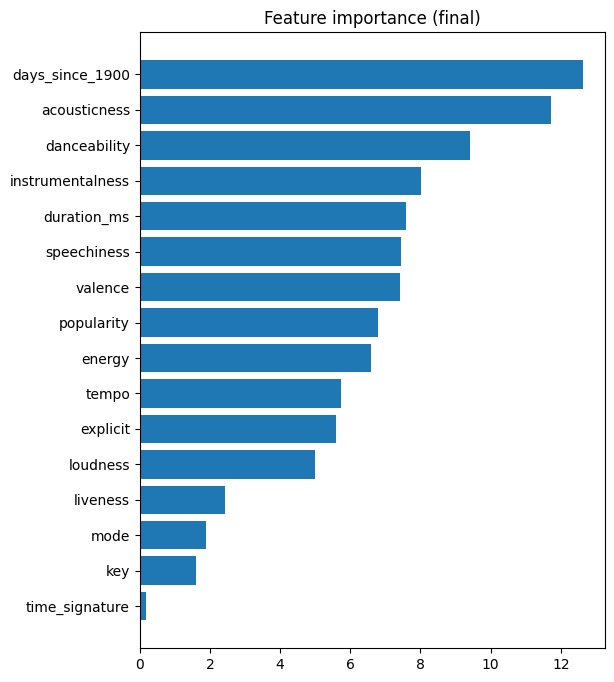

In [ ]:
# ...existing code...
%pip install catboost
from catboost import CatBoostClassifier, Pool
from IPython.display import clear_output

train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# paramètres
total_iters = 500
batch = 10    # update plot every `batch` iters
lr = 0.05

# entraînement incrémental pour plot "live"
prev_model = None
train_history = []
val_history = []

for start in range(0, total_iters, batch):
    cb = CatBoostClassifier(
        iterations=batch,
        learning_rate=lr,
        eval_metric='MultiClass',
        random_seed=42,
        verbose=False,
        use_best_model=False
    )
    cb.fit(train_pool, eval_set=val_pool, init_model=prev_model, verbose=False)
    prev_model = cb

    ev = cb.get_evals_result()
    metric = list(ev['learn'].keys())[0]
    train_vals = ev['learn'][metric]
    val_vals = ev['validation'][metric]

    train_history.extend(train_vals)
    val_history.extend(val_vals)

    # affichage live
    clear_output(wait=True)
    plt.figure(figsize=(8,4))
    plt.plot(train_history, label=f"train_{metric}")
    plt.plot(val_history, label=f"val_{metric}")
    plt.xlabel("Iteration")
    plt.ylabel(metric)
    plt.legend()
    plt.title("Courbe d'entraînement (live)")
    plt.grid(alpha=0.3)
    plt.show()

# prédictions finales
y_pred_val = prev_model.predict(X_val).ravel()

# importance des features (finale)
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': prev_model.get_feature_importance()
}).sort_values('importance', ascending=True)

plt.figure(figsize=(6,8))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.title("Feature importance (final)")
plt.show()
# ...existing code...

In [ ]:
print("="*40)
print(f"F1 Score (micro): {f1_score(y_val, y_pred_val, average='micro'):.4f}")
print(f"F1 Score (macro): {f1_score(y_val, y_pred_val, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_val, y_pred_val, average='weighted'):.4f}")
print('='*40)
print("Accuracy : ", accuracy_score(y_val, y_pred_val))
print('='*40)

F1 Score (micro): 0.4842
F1 Score (macro): 0.3497
F1 Score (weighted): 0.4531
Accuracy :  0.48421259070405964


In [ ]:
print("="*40)
print(f"F1 Score (micro) without popularity=0: {f1_score(y_val_nozero, y_pred_val_nozero, average='micro'):.4f}")
print('='*40)
print("Accuracy without popularity=0 : ", accuracy_score(y_val_nozero, y_pred_val_nozero))
print('='*40)

F1 Score (micro) without popularity=0: 0.4658
Accuracy without popularity=0 :  0.46575716234652115


In [ ]:
print("="*40)
print(f"F1 Score KDE (micro): {f1_score(y_val, y_pred_val_KDE, average='micro'):.4f}")
print('='*40)
print("Accuracy KDE : ", accuracy_score(y_val, y_pred_val_KDE))
print('='*40)

F1 Score KDE (micro): 0.4799
Accuracy KDE :  0.4798980192194548


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

le_cv = LabelEncoder()
y_enc = le_cv.fit_transform(y)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_cv = LGBMClassifier(n_estimators=500, random_state=42, verbose=-1)

# scoring='f1_micro' pour obtenir des scores F1 (micro)
scores = cross_val_score(clf_cv, X, y_enc, cv=cv, scoring='f1_micro', n_jobs=-1)
print('CV f1_micro scores:', scores)
print('Mean CV f1_micro:', scores.mean())

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)
px.imshow(cm, x=sorted(y_val.unique()), y=sorted(y_val.unique()), text_auto=True, 
          color_continuous_scale='Plasma', template='plotly_dark',
          width=800, height=700)

## Classification - SVM

In [ ]:
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

y_pred_val_svm = svm.predict(X_val)

In [ ]:
svm_nozero = SVC(kernel='rbf', random_state=42)
svm_nozero.fit(X_train_nozero, y_train_nozero)

y_pred_val_svm_nozero = svm_nozero.predict(X_val_nozero)

In [ ]:
svm_kde = SVC(kernel='rbf', random_state=42)
svm_kde.fit(X_train_kde, y_train_kde)
y_pred_val_svm_kde = svm_kde.predict(X_val_kde)

In [ ]:
print("="*40)
print(f"SVM F1 Score (micro): {f1_score(y_val, y_pred_val_svm, average='micro'):.4f}")
print('='*40)
print("Accuracy : ", accuracy_score(y_val, y_pred_val_svm))
print('='*40)

SVM F1 Score (micro): 0.2622
Accuracy :  0.262208276132575


In [ ]:
print("="*40)
print(f"SVM F1 Score (micro) without popularity=0: {f1_score(y_val_nozero, y_pred_val_svm_nozero, average='micro'):.4f}")
print('='*40)
print("Accuracy without popularity=0 : ", accuracy_score(y_val_nozero, y_pred_val_svm_nozero))
print('='*40)

SVM F1 Score (micro) without popularity=0: 0.2649
Accuracy without popularity=0 :  0.2649386084583902


In [ ]:
print("="*40)
print(f"F1 Score KDE (micro): {f1_score(y_val, y_pred_val_svm_kde, average='micro'):.4f}")
print('='*40)
print("Accuracy KDE : ", accuracy_score(y_val, y_pred_val_svm_kde))
print('='*40)

F1 Score KDE (micro): 0.2622
Accuracy KDE :  0.262208276132575


In [ ]:
cm_svm = confusion_matrix(y_val, y_pred_val_svm)
px.imshow(cm_svm, x=sorted(y_val.unique()), y=sorted(y_val.unique()), text_auto=True, 
          color_continuous_scale='Plasma', template='plotly_dark')


## Classification - RandomForest

In [ ]:
RandomForest = RandomForestClassifier(n_estimators=100, random_state=42)
RandomForest.fit(X_train, y_train)

y_pred_val_rf = RandomForest.predict(X_val)

In [ ]:
RandomForest_nozero = RandomForestClassifier(n_estimators=100, random_state=42)
RandomForest_nozero.fit(X_train_nozero, y_train_nozero)
y_pred_val_rf_nozero = RandomForest_nozero.predict(X_val_nozero)


In [ ]:
RandomForest_kde = RandomForestClassifier(n_estimators=100, random_state=42)
RandomForest_kde.fit(X_train_kde,y_train_kde)
y_pred_val_rf_kde = RandomForest_kde.predict(X_val_kde)

In [ ]:
print("="*40)
print(f"SVM F1 Score (micro): {f1_score(y_val, y_pred_val_rf, average='micro'):.4f}")
print('='*40)
print("Accuracy : ", accuracy_score(y_val, y_pred_val_rf))
print('='*40)

SVM F1 Score (micro): 0.4730
Accuracy :  0.47303392822121987


In [ ]:
print("="*40)
print(f"RandomForest F1 Score (micro) without popularity=0: {f1_score(y_val_nozero, y_pred_val_rf_nozero, average='micro'):.4f}")
print('='*40)
print("Accuracy without popularity=0 : ", accuracy_score(y_val_nozero, y_pred_val_rf_nozero))
print('='*40)

RandomForest F1 Score (micro) without popularity=0: 0.4764
Accuracy without popularity=0 :  0.47639836289222376


In [ ]:
print("="*40)
print(f"RandomForest F1 Score KDE : {f1_score(y_val_kde,y_pred_val_rf_kde, average='micro'):.4f}")
print("="*40)

RandomForest F1 Score KDE : 0.4766


In [ ]:
cm_rf = confusion_matrix(y_val, y_pred_val_rf)
px.imshow(cm_rf, x=sorted(y_val.unique()), y=sorted(y_val.unique()), text_auto=True, 
          color_continuous_scale='Plasma', template='plotly_dark', width=800, height=700)

## Classification - XGBoost

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

xgb_model = XGBClassifier(n_estimators=500, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train_enc)

y_pred_val_xgb = le.inverse_transform(xgb_model.predict(X_val))

In [ ]:
le_nozero = LabelEncoder()
y_train_enc_no = le_nozero.fit_transform(y_train_nozero)
y_val_enc_no = le_nozero.transform(y_val_nozero)

xgb_model_nozero = XGBClassifier(n_estimators=500, random_state=42, verbosity=0)
xgb_model_nozero.fit(X_train_nozero, y_train_enc_no)
y_pred_val_xgb_nozero = le_nozero.inverse_transform(xgb_model_nozero.predict(X_val_nozero))

In [ ]:
print("="*40)
print(f"XGBoost F1 Score (micro): {f1_score(y_val, y_pred_val_xgb, average='micro'):.4f}")
print('='*40)
print("Accuracy : ", accuracy_score(y_val, y_pred_val_xgb))
print('='*40)

XGBoost F1 Score (micro): 0.4807
Accuracy :  0.48068248676211023


In [ ]:
print("="*40)
print(f"XGBoost F1 Score (micro) without popularity=0: {f1_score(y_val_nozero, y_pred_val_xgb_nozero, average='micro'):.4f}")
print('='*40)
print("Accuracy without popularity=0 : ", accuracy_score(y_val_nozero, y_pred_val_xgb_nozero))
print('='*40)

XGBoost F1 Score (micro) without popularity=0: 0.4641
Accuracy without popularity=0 :  0.46412005457025923


In [ ]:
cm_xgb = confusion_matrix(y_val, y_pred_val_xgb)
px.imshow(cm_xgb, x=sorted(y_val.unique()), y=sorted(y_val.unique()), text_auto=True, 
          color_continuous_scale='Plasma', template='plotly_dark',
          width=800, height=700)

## Clalssification - HistGradientBoostingClassifier

In [ ]:
HGBC = HistGradientBoostingClassifier().fit(X_train,y_train)
y_pred_HGBC = HGBC.predict(X_val)

In [ ]:
HGBC_nozero = HistGradientBoostingClassifier().fit(X_train_nozero,y_train_nozero)
y_pred_HGBC_nozero = HGBC_nozero.predict(X_val_nozero)

In [ ]:
print("="*40)
print(f"HGBC F1 Score (micro): {f1_score(y_val, y_pred_HGBC, average='micro'):.4f}")
print('='*40)
print(f"HGBC F1 Score (micro) without popularity=0: {f1_score(y_val_nozero, y_pred_HGBC_nozero, average='micro'):.4f}")
print('='*40)

HGBC F1 Score (micro): 0.4713
HGBC F1 Score (micro) without popularity=0: 0.4636


In [ ]:
print("="*40)
print(f"F1 Score (micro) without popularity=0: {f1_score(y_val_nozero, y_pred_val_nozero, average='micro'):.4f}")
print('='*40)
print("Accuracy without popularity=0 : ", accuracy_score(y_val_nozero, y_pred_val_nozero))
print('='*40)

F1 Score (micro) without popularity=0: 0.4658
Accuracy without popularity=0 :  0.46575716234652115


## Data analysis

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
dataset_train_subset_path = 'dataset_part_1/dataset/spotify_dataset_subset.csv'
dataset_subset = pd.read_csv(dataset_train_subset_path)

# Correct OneHotEncoder usage: provide 2D input and expand encoded columns
OHE = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
genres_enc = OHE.fit_transform(dataset_subset[['genres']])
genre_cols = OHE.get_feature_names_out(['genres'])
df_genres_enc = pd.DataFrame(genres_enc, columns=genre_cols, index=dataset_subset.index)
dataset_subset = pd.concat([dataset_subset, df_genres_enc], axis=1)

dataset_subset['release_date'] = pd.to_datetime(dataset_subset['release_date'],format='mixed')
min_date = dataset_subset['release_date'].min()
dataset_subset['days_since_1900'] = (dataset_subset['release_date'] - min_date).dt.days

features_reg = ['days_since_1900','explicit','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'] + list(genre_cols)

X_sub = dataset_subset[features_reg]
y_sub = dataset_subset['popularity']

xgb_reg = XGBRegressor()
xgb_reg.fit(X_sub, y_sub)

y_pred_popularity = xgb_reg.predict(X_sub)

ValueError: feature_names must be string, and may not contain [, ] or <

In [ ]:
print("="*40)
print(f"R² Score: {xgb_reg.score(X_sub, y_sub):.4f}")
print('='*40)
print(f"MAE: {np.mean(np.abs(y_sub - y_pred_popularity)):.4f}")
print('='*40)

R² Score: 0.8148
MAE: 8.6277


In [ ]:
dataset_subset['predicted_popularity'] = y_pred_popularity

fig = px.scatter(dataset_subset, x='popularity', y='predicted_popularity', 
                 opacity=0.5, template='plotly_dark',
                 labels={'popularity': 'Real Popularity', 'predicted_popularity': 'Predicted Popularity'},
                 title='Real vs Predicted Popularity')

fig.add_shape(type='line', x0=0, y0=0, x1=100, y1=100, 
              line=dict(color='red', dash='dash'))

fig.update_layout(width=800, height=600)
fig.show()

In [ ]:
importances = pd.DataFrame({
    'feature': X_sub.columns,
    'importance': xgb_reg.feature_importances_
}).sort_values('importance', ascending=True)

fig = px.bar(importances, x='importance', y='feature', orientation='h',
             title='Feature Importance for Popularity Prediction', template='plotly_dark')
fig.show()

## Song recommendation

In [ ]:
dataset_recommendation_path = 'dataset_part_1\dataset\recommendation_spotify.csv'
dataset_recommendation = pd.read_csv(dataset_recommendation_path)

In [ ]:
correlation_matrix = dataset_recommendation.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='plasma')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   release_date      2833 non-null   object 
 1   explicit          2833 non-null   bool   
 2   popularity        2833 non-null   int64  
 3   danceability      2833 non-null   float64
 4   energy            2833 non-null   float64
 5   key               2833 non-null   int64  
 6   loudness          2833 non-null   float64
 7   mode              2833 non-null   int64  
 8   speechiness       2833 non-null   float64
 9   acousticness      2833 non-null   float64
 10  instrumentalness  2833 non-null   float64
 11  liveness          2833 non-null   float64
 12  valence           2833 non-null   float64
 13  tempo             2833 non-null   float64
 14  duration_ms       2833 non-null   int64  
 15  time_signature    2833 non-null   int64  
dtypes: bool(1), float64(9), int64(5), object(1

,release_date,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2018-03-16,True,83,0.699,0.304,1,-11.192,1,0.0993,0.77900,0.000993,0.1370,0.271,119.705,160184,4
1,2003,False,44,0.590,0.722,4,-5.783,1,0.0265,0.00052,0.000009,0.0712,0.670,116.035,166645,4
2,2012-01-01,False,0,0.362,0.435,2,-7.241,1,0.0280,0.27400,0.000001,0.1580,0.349,141.970,220693,4
3,2001-10-23,False,57,0.571,0.617,2,-5.032,1,0.0348,0.32800,0.000000,0.1150,0.574,88.154,187373,4
4,2020-09-18,False,56,0.578,0.748,0,-5.609,0,0.0460,0.03260,0.002550,0.1430,0.170,123.973,185806,4
